In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import sklearn.datasets as datasets
from sklearn.metrics import pairwise_distances
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
sns.set_context('poster')

import numpy as np
import requests
import tarfile
import imageio
import cv2
import glob
import os

### Dimension Reduction Analysis

#### Goal

Effectively assess dimension reduction quality, and make it easy for others to do so as well. 

The desired punch line: here are the best ways to assess quality of your dimension reduction based on what you want your dimension reduction to preserve (paper), and here's how to easily check yourself on your own data (codebase). This should all come in a single handy framework with an easy to use API. 

#### Tasks

* Review and reproduce results existing quality measures. Create a cohesive easy to use interface along the way for comparing high vs. low space using whatever quality measure you'd like. 
    * ***Datasets:***
        * Synthetic
        * Natural (aka. real world)
            * MNIST
            * F-MNIST
            * COIL-20
    * ***Dimension Reduction Techniques:*** Preference to techniques that are implemented in sklearn and other standard python libraries or that are otherwise widely used.
        * PCA
        * MDS
        * Isomap
        * t-SNE
        * autoencoder
        * UMAP
        * Maybe others: (try them and then see if they add anything to the overall review)
    * ***Quality measures:***
        * Stress
        * Trustworthiness
        * Continuity
        * Generalization errors of 1-NN classifiers?
        * Quality score from coranking matrix
* Include visualization options (when reducing to 2/3 dimensional space)   
* Do the same analysis adding our local neighbourhood scores
* Make
        

#### References

* [***MPH2009***](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf): 2009 review of 12 dimension reduction techniques on 10 datasets (5 synthetic, 5 natural) using trustworthiness, continuity, and generalization errors of 1-NN classifiers. Techniques used were  
    * Kernel PCA, 
    * Isomap
    * Maximum Variance Unfolding
    * diffusion maps
    * Locally Linear Embedding
    * Laplacian Eigenmaps
    * Hessian LLE
    * Local Tangent Space Analysis
    * Sammon mapping
    * multilayer autoencoders
    * Locally Linear Coordination
    * manifold charting.
* [***S2015***](http://journals.sagepub.com/doi/pdf/10.1177/1473871613504102): 2015 comparison  of DR techniques on financial data using metric MDS, Sammon’s mapping, and the SOM. "Rather than being the most recent methods, the rationale for comparing these methods is to capture the suitability of well-known dimension reduction methods with inherently different aims: global and local distance preservation and topology preservation. For DDR, we test serial and parallel combinations of the projections with three data reduction or compression methods: vector quantization (VQ),16 k-means clustering,17 and Ward’s18 hierarchical clustering."
* [***LOV2015***](https://www.sciencedirect.com/science/article/pii/S0925231215003641) Use of the follow on from the quality assessment from the co-ranking metric with an algorithm that is better via that score.
* [***LV2008***](http://proceedings.mlr.press/v4/lee08a/lee08a.pdf): Trustworthiness, continuity and the coranking matrix.

#### Bibtex

    @article{MPH2009,
      title={Dimensionality reduction: a comparative review},
      author={Van Der Maaten, Laurens and Postma, Eric and Van den Herik, Jaap},
      journal={J Mach Learn Res},
      volume={10},
      pages={66--71},
      year={2009}
    } 
    
    @article{S2015,
      title={Data and dimension reduction for visual financial performance analysis},
      author={Sarlin, Peter},
      journal={Information Visualization},
      volume={14},
      number={2},
      pages={148--167},
      year={2015},
      publisher={Sage Publications Sage UK: London, England}
    }
    
    @article{LOV2015,
      title={Multi-scale similarities in stochastic neighbour embedding: Reducing dimensionality while preserving both local and global structure},
      author={Lee, John A and Peluffo-Ord{\'o}{\~n}ez, Diego H and Verleysen, Michel},
      journal={Neurocomputing},
      volume={169},
      pages={246--261},
      year={2015},
      publisher={Elsevier}
    }
    
    @inproceedings{LV2008,
      title={Quality assessment of nonlinear dimensionality reduction based on K-ary neighborhoods},
      author={Lee, John and Verleysen, Michel},
      booktitle={New Challenges for Feature Selection in Data Mining and Knowledge Discovery},
      pages={21--35},
      year={2008}
    }

### Use PCA on MNIST to get high/low data for first example

In [23]:
from sklearn.datasets import fetch_mldata
digits = fetch_mldata('MNIST original')

In [5]:
%%time
if not os.path.exists('coil-100'):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.tar.gz')
    with open("coil_100.tar.gz", "wb") as code:
        code.write(results.content)

    images_zip = tarfile.open('coil_100.tar.gz', mode='r:gz')
    images_zip.extractall()

CPU times: user 14.4 s, sys: 4.22 s, total: 18.6 s
Wall time: 1min 9s


In [7]:
feature_vectors = []
filelist = glob.glob('./coil-100/*.ppm')
for filename in filelist:
    im = cv2.imread(filename)
    feature_vectors.append(im.flatten())

In [15]:
high_labels = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False)

In [10]:
high_data = np.vstack(feature_vectors)
print(high_data.shape)

(7200, 49152)


In [12]:
pca = PCA(n_components=2, svd_solver='arpack')

In [16]:
%%time
low_data = pca.fit_transform(high_data)

CPU times: user 25.1 s, sys: 14.5 s, total: 39.6 s
Wall time: 1min 9s


In [17]:
low_labels = high_labels

In [18]:
def two_dim_label_viz(data, labels, cmap="Blues", s=10, **kwargs):
    """
    Plot data using labels as the color scheme.
    
    Parameters
    ----------
    data: 2d np array
    labels: labels
    any other plt.scatter options
    """
    plt.scatter(data[:,0], data[:,1], c=labels, cmap=cmap, s=s, **kwargs)
    plt.colorbar();

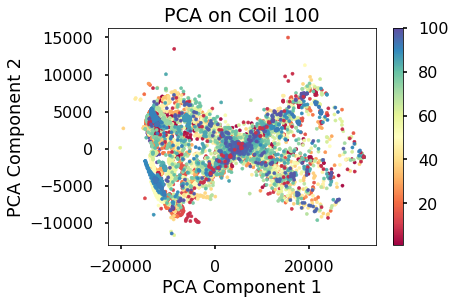

In [20]:
two_dim_label_viz(low_data, low_labels, cmap="Spectral", s=10)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA on COil 100");

### Quality score using stress

Metric MDS

$$ Stress_{D}(x_{1},x_{2},...,x_{N})={\Biggl (}\sum _{i\neq j=1,...,N}{\bigl (}d_{ij}-\|x_{i}-x_{j}\|{\bigr )}^{2}{\Biggr )}^{1/2}$$

### Proof of concept: Do not do this with large data O($N^2$)

In [21]:
%%time
high_distances = pairwise_distances(high_data, metric='euclidean')

CPU times: user 1min 14s, sys: 9.13 s, total: 1min 23s
Wall time: 27.6 s


In [22]:
low_distances = pairwise_distances(low_data, metric='euclidean')

In [23]:
difference_distances = high_distances-low_distances
s_difference_distances = difference_distances**2
stress = np.sqrt(np.sum(s_difference_distances))

Relative local contributions could be computed via row sums of the differences between the distances...or the sqrt of the row sums of the squared difference of the distances.

In [24]:
def pairwise_distance_difference(high_data, low_data, metric='euclidean'):
    high_distances = pairwise_distances(high_data, metric=metric)
    low_distances = pairwise_distances(low_data, metric=metric)
    difference_distances = high_distances-low_distances
    return difference_distances

In [25]:
def point_stress(difference_distances, metric='euclidean'):
    s_difference_distances = difference_distances**2
    point_stress = np.sum(s_difference_distances, axis=1)
    return point_stress

In [26]:
def stress(difference_distances, metric='euclidean'):
    s_difference_distances = difference_distances**2
    stress = np.sqrt(np.sum(s_difference_distances))
    return stress

In [27]:
pca_diff_distances = pairwise_distance_difference(high_data, low_data)
pca_point_stress = point_stress(pca_diff_distances)
pca_stress = stress(pca_diff_distances)

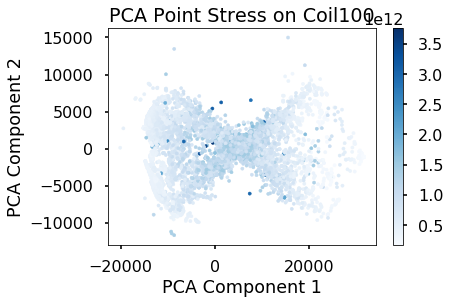

In [28]:
two_dim_label_viz(low_data, pca_point_stress, s=3, alpha=0.75)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Point Stress on Coil100");

## metric MDS and digits

If I did this correctly, the above stress function should work the same as MDS.

In [29]:
mds = MDS(n_components=2, metric=True)

This usually takes...2 mins...

In [30]:
%%time
mds_low_data = mds.fit_transform(high_data)

CPU times: user 1h 20min 20s, sys: 22min 1s, total: 1h 42min 22s
Wall time: 34min 14s


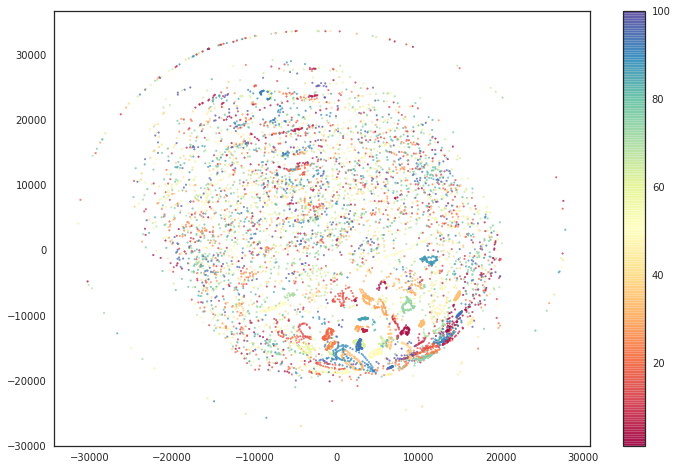

In [32]:
sns.set(style='white', rc={'figure.figsize':(12,8)})
two_dim_label_viz(mds_low_data, low_labels, cmap="Spectral", s=3, alpha=0.75)

In [33]:
mds.stress_

1030825896601538.1

In [34]:
mds_diff_distances = pairwise_distance_difference(high_data, mds_low_data)

In [35]:
(stress(mds_diff_distances))**2/2

1030751330880093.8

In [36]:
np.sqrt(mds.stress_*2)

45405415.90166394

In [37]:
stress(mds_diff_distances)

45403773.65109851

hmmm...off by a multiple of 2...where would that come from?

In [38]:
mds_stress = stress(mds_diff_distances)
mds_point_stress = point_stress(mds_diff_distances)

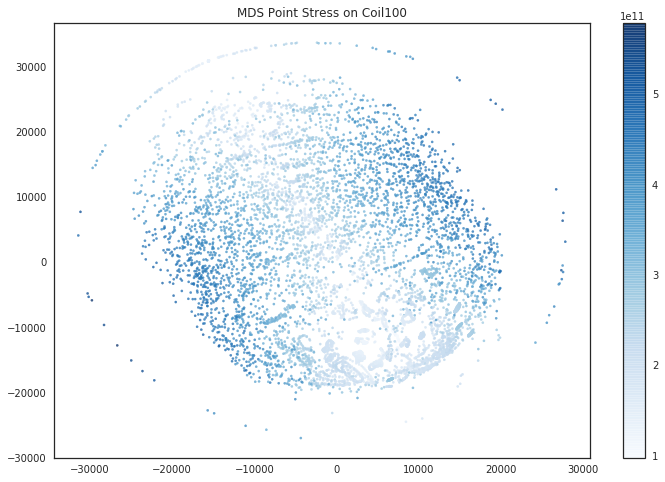

In [41]:
two_dim_label_viz(mds_low_data, mds_point_stress, s=5, alpha=0.75)
plt.title("MDS Point Stress on Coil100");

/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


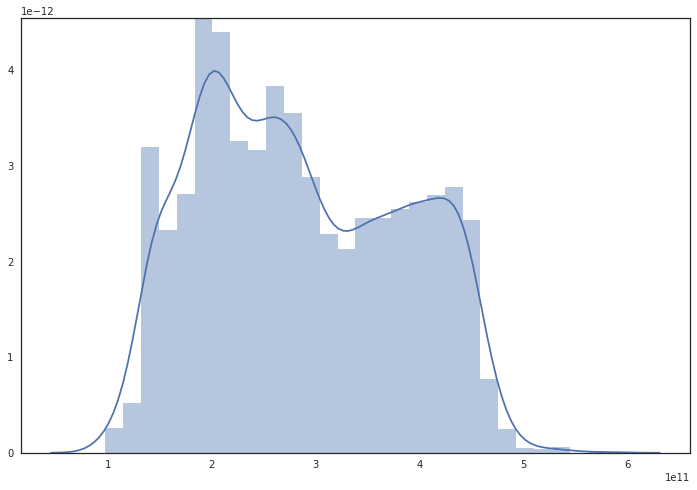

In [43]:
sns.distplot(mds_point_stress);

### Classical MDS
(Optimal solution is given by PCA)

$$\textstyle Strain_{D}(x_{1},x_{2},...,x_{N})={\Biggl (}{\frac {\sum _{i,j}{\bigl (}b_{ij}-\langle x_{i},x_{j}\rangle {\bigr )}^{2}}{\sum _{i,j}b_{ij}^{2}}}{\Biggr )}^{1/2}$$

where $B = -\frac{1}{2} J D^{(2)}J$ and $J = I_{N}-{\tfrac  {1}{N}}{\mathbf  {1}}{\mathbf  {1}}^{\top }$ where $\mathbf  {1}$ is the $N$-dimensional vector of 1's. 

In [89]:
N = len(diff_distances); N

1797

In [90]:
I_N = np.identity(N)
one_N = np.matrix(np.ones(N)).transpose()
J = I_N - one_N * one_N.transpose()/N
B = -J * diff_distances**2 * J/2

In [91]:
M = B - diff_distances
M = M**2
result = np.sqrt(np.sum(M)/np.sum(np.array(B)**2))

In [92]:
result

5.5817635416133777

In [98]:
local_contributions = np.sum(np.array(M), axis=1)/np.sum(np.array(B)**2, axis=1)

In [239]:
def strain(diff_distances):
    diff_distances = np.array(diff_distances)
    N = len(diff_distances)
    I_N = np.identity(N)
    one_N = np.matrix(np.ones(N)).transpose()
    J = I_N - one_N * one_N.transpose()/N
    B = -J * diff_distances**2 * J/2
    M = B - diff_distances
    M = np.array(M)**2 # want entry-wise squares
    return np.sqrt(np.sum(M)/np.sum(np.array(B)**2))

def point_strain(diff_distances):
    N = len(diff_distances)
    diff_distances = np.array(diff_distances)
    I_N = np.identity(N)
    one_N = np.matrix(np.ones(N)).transpose()
    J = I_N - one_N * one_N.transpose()/N
    B = -J * diff_distances**2 * J/2
    M = B - diff_distances
    M = np.array(M)**2# want entry-wise squares
    return np.sum(M, axis=1)

In [269]:
pca_strain = strain(pca_diff_distances); pca_strain

1.0420256814210926

In [241]:
pca_point_strain = point_strain(pca_diff_distances)

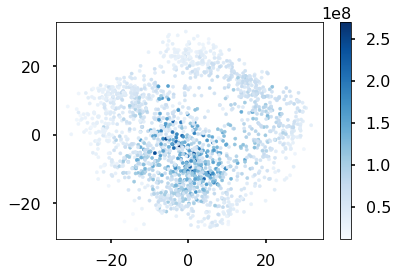

In [242]:
two_dim_label_viz(low_data, pca_point_strain)

In [270]:
mds_strain = strain(mds_diff_distances); mds_strain

1.0556964004328464

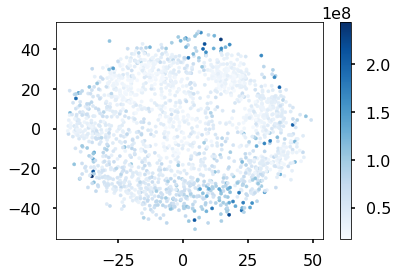

In [244]:
mds_point_strain = point_strain(mds_diff_distances)
two_dim_label_viz(mds_low_data, mds_point_strain)

In [245]:
## Hmmmm...now I want these to be on the same color bars

In [246]:
data = [low_data, mds_low_data]
labels = [pca_point_stress, mds_point_stress]
titles = ['PCA', 'MDS']

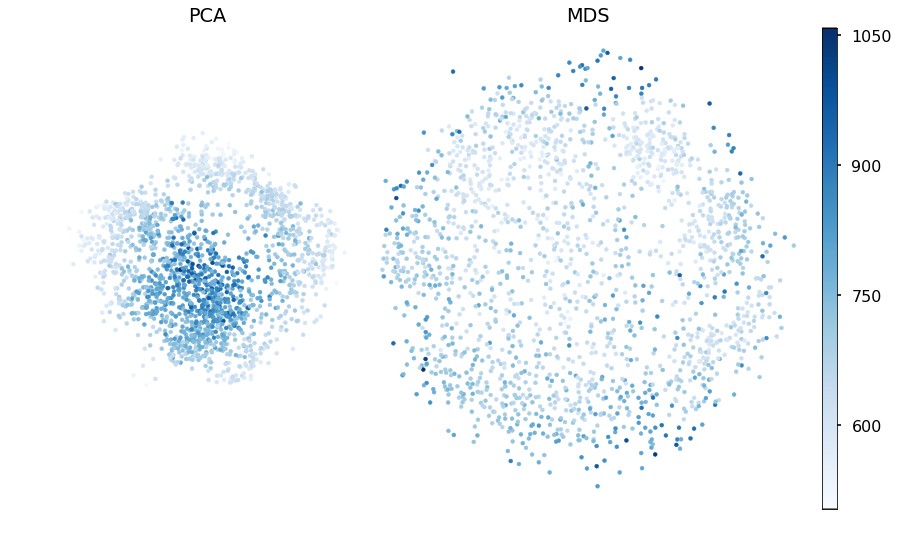

In [247]:
nrows = 1
ncols = 2
s = 15
cmap = "Blues"

fig = plt.figure(figsize=(14, 10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.scatter(data[i][:,0], data[i][:,1], c=labels[i], cmap=cmap, s=s)
    ax.set_title(title[i])
    #im = ax.imshow(np.random.random((16,16)), vmin=0, vmax=1)

# when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]

cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

#cbar.ax.set_yticks(np.arange(0, 1.1, 0.5))
#cbar.ax.set_yticklabels(['low', 'medium', 'high'])
plt.title("Point Stress")
plt.show()

In [284]:
def two_dim_multiplot(data, labels, titles, cmap="Blues", s=15, **kwargs):
    ncols = 2
    nrows = int(len(data)/ncols)
    
    fig = plt.figure(figsize=(14*nrows, 5*ncols))

    grid = AxesGrid(fig, 111,
                    nrows_ncols=(nrows, ncols),
                    axes_pad=0.05,
                    cbar_mode='single',
                    cbar_location='right',
                    cbar_pad=0.1
                    )

    for i, ax in enumerate(grid):
        ax.set_axis_off()
        im = ax.scatter(data[i][:,0], data[i][:,1], c=labels[i], cmap=cmap, s=s)
        ax.set_title(titles[i])

    # when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]

    cbar = ax.cax.colorbar(im)
    cbar = grid.cbar_axes[0].colorbar(im);


## Comparisons 

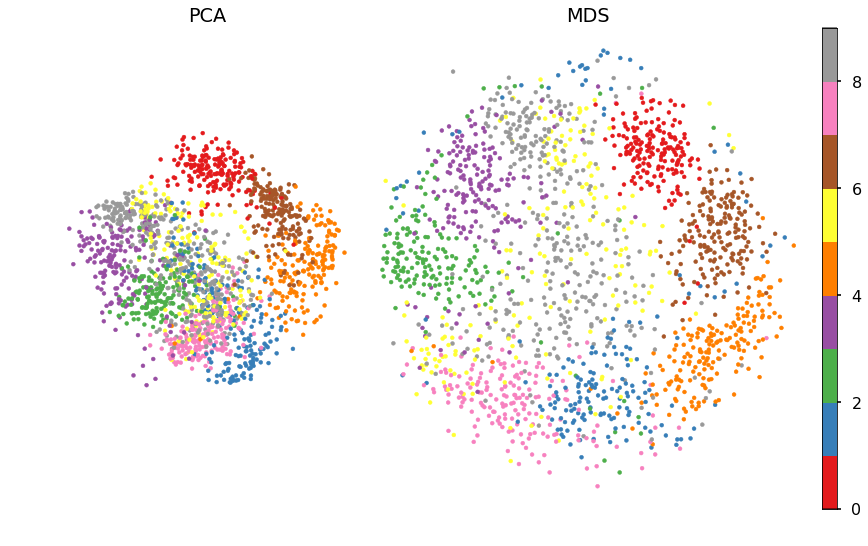

In [249]:
data = [low_data, mds_low_data]
labels = [low_labels, low_labels]
titles = ['PCA', 'MDS']

two_dim_multiplot(data, labels, titles, cmap="Set1")

### Stress (Metric MDS)

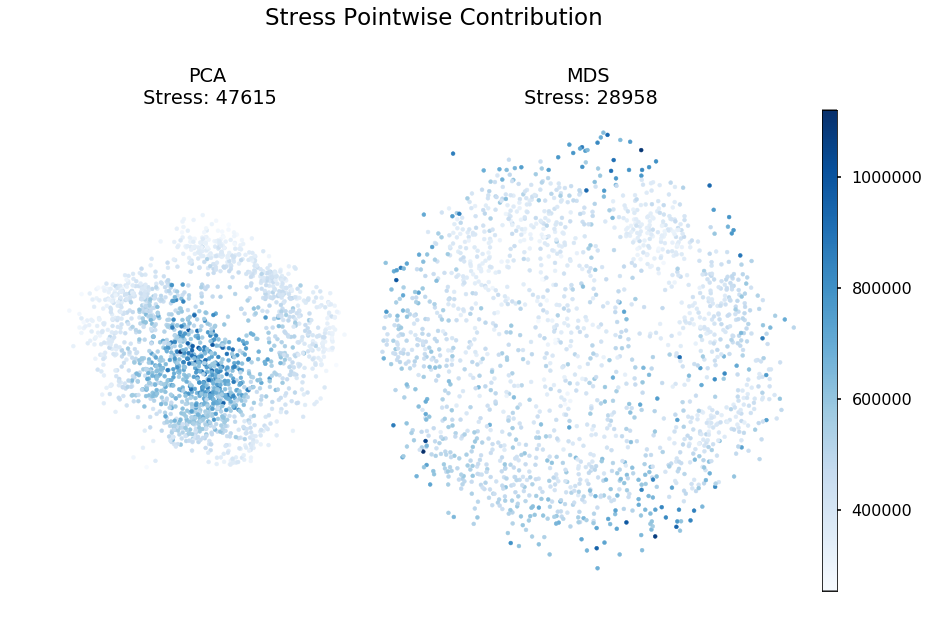

In [283]:
data = [low_data, mds_low_data]
labels = [pca_point_stress, mds_point_stress]
titles = [f'PCA\n Stress: {int(pca_stress)}', f'MDS\n Stress: {int(mds_stress)}']

two_dim_multiplot(data, labels, titles)
plt.suptitle("Stress Pointwise Contribution");

### Strain (Classical MDS/PCA)

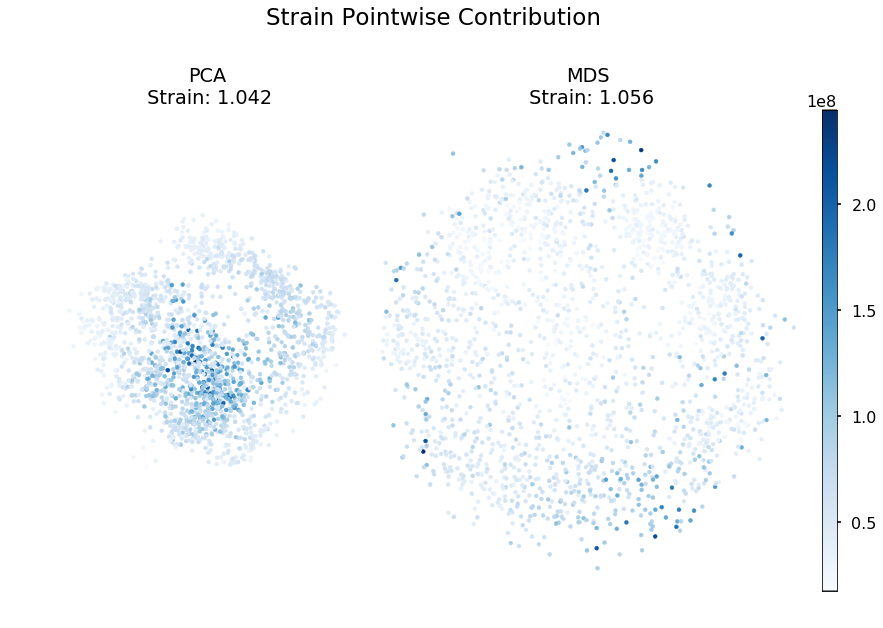

In [282]:
width = 4
precision = 4
data = [low_data, mds_low_data]
labels = [pca_point_strain, mds_point_strain]
titles = [f'PCA\n Strain: {pca_strain:{width}.{precision}}', f'MDS\n Strain: {mds_strain:{width}.{precision}}']

two_dim_multiplot(data, labels, titles)
plt.suptitle("Strain Pointwise Contribution");